## Overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.




The structure of this notebook is as follows:

 - First, we'll load our data to get a view of the predictor and response variables we will be modeling. 
 - We'll then preprocess our data, binarising the target variable and splitting up the data intro train and test sets. 
 - We then model our data using a Support Vector Classifier.
 - Following this modeling, we define a custom metric as the log-loss in order to evaluate our produced model.
 - Using this metric, we then take several steps to improve our base model's performance by optimising the hyperparameters of the SVC through a grid search strategy. 

In [ ]:
image = Image.open("C:/Users/Mpilenhle\Documents/EDSA/Classification/classification-predict-streamlit-model/resources/imgs/worl.jpg")


In [93]:
# import relevant libraries
import nltk
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
pd.set_option('display.max_rows', 100)
from sklearn.utils import resample
from sklearn.pipeline import Pipeline


from nltk.corpus import stopwords
from sklearn.metrics import classification_report

# set plot style
# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud


In [148]:
b

## The Dataset 

Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:
## Class description:
 
 - 0 -->  Neutral: the tweet neither supports nor refutes the belief of man-made climate change
 - 1 -->  Pro: the tweet supports the belief of man-made climate change
 - 2 -->  News: the tweet links to factual news about climate change
 - -1 --> Anti: the tweet does not believe in man-made climate change

 
## Columns of the training data:
This dataset consists of the following Columns: 

 - sentiments
 - message
 - tweetid



In [150]:
# looking at the data
df_train.shape

(15819, 3)

In [151]:
df_test.shape

(10546, 2)

In [152]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [153]:
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Data distribution of classes 

 By looking at the value count of classes we suddenly see imbalance in the data

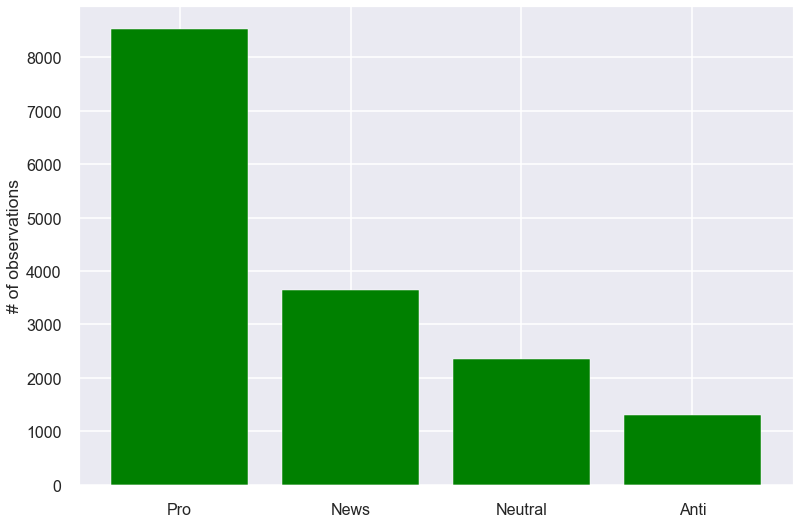

In [210]:
labels = ['Pro', 'News', 'Neutral', 'Anti'] 

# Get all possible labels
plt.bar(labels,df_train['sentiment'].value_counts() ,color='green')
plt.xticks(labels, ['Pro', 'News', 'Neutral', 'Anti'] )
plt.ylabel("# of observations")
plt.show()

# Data Cleaning
The tweets have a lot of charecters that might cause noise in our data, with the use of regualr expressions we can remove those charecters which include:
 - Hashtags
 - RT for retweets
 - @ for mentions
 - url webs
 - emojis
 - digits
 - spelling charecters eg. ã¢â‚¬â¦

By removing these charecters we atrying to remove words that do not make sense for the model, the lesser the noise the more precise the results we are getting, this is also done to avoid learning wrong patterns from the data


In [234]:


                        """
                        The function uses some of the functions remove_emoji() which removes
                        emojis in a tweet
                        it also uses the function remove_punctuation() which removes
                        punctuations

                        The function data_cleaner() implements both these functions to make a 
                        clean data frame, with the use of the regular expressions it removes
                        noise or unwanted charecters in the tweets


                        """

import string
import re
#creating a function for removing emojis
def remove_emoji(string):
    emoji_pattern = re.compile("[" 
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


# punctuation remover function
def remove_punctuation(tweets):
    return ''.join([l for l in tweets if l not in string.punctuation])



def data_cleaner(df, column):
    
    #remmoving the urls
    pattern_url = r'http[s]?://[A-Za-z0-9/.]+'
    subs_url = r'url-web'
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)
    
    #remmoving the Re Tweets 
    pattern_url = r'RT\s'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)
    

    #remmoving the mentions 
    pattern_url = r'@'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)


    #remmoving the Hashtags 
    pattern_url = r'\#'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)
    

    #remmoving the remaining https
    pattern_url = r'https:[.*?]+'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)

    #remmoving the digits
    pattern_url = r'\d'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)

    # turning all tweets to lower case
    df[column] = df[column].str.lower()
    
    # using apply method to remove the punctuation marks
    df[column] = df[column].apply(remove_punctuation)
    
    # Removing the emojis using the apply method
    df[column] = df[column].apply(remove_emoji)
    
    #remmoving the uknown charecters from words
    pattern_url = r'[^A-Za-z ]'
    subs_url = r''
    df[column] = df[column].replace(to_replace = pattern_url, value = subs_url, regex = True)

    
    return df

In [165]:
# Call the function data_cleaner() and clean the training data frame 
clean_df_train = data_cleaner(df_train, 'message')

In [166]:
# Call the function data_cleaner and clean the testing data frame 
clean_df_test = data_cleaner(df_test, 'message')

In [167]:
# looking at the clean training data
clean_df_train

,sentiment,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences,stem_clean_sentences,lemma_stem_clean_sentences
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]",like lack evidence anthropogenic global warming,like lack evid anthropogen global warm,like lack evid anthropogen global warm
2,2,rawstory researchers say we have three years t...,698562,"[rawstory, researchers, say, we, have, three, ...","[rawstory, researchers, say, three, years, act...","[rawstory, researcher, say, three, year, act, ...","[rawstori, research, say, three, year, act, cl...",rawstory researchers say three years act clima...,rawstori research say three year act climat ch...,rawstori research say three year act climat ch...
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmak, wire, pivot, year, war, climat, c...",todayinmaker wired pivotal year war climate ch...,todayinmak wire pivot year war climat chang ur...,todayinmak wire pivot year war climat chang ur...
4,1,soynoviodetodas its and a racist sexist clima...,466954,"[soynoviodetodas, its, and, a, racist, sexist,...","[soynoviodetodas, racist, sexist, climate, cha...","[soynoviodetodas, racist, sexist, climate, cha...","[soynoviodetoda, racist, sexist, climat, chang...",soynoviodetodas racist sexist climate change d...,soynoviodetoda racist sexist climat chang deni...,soynoviodetoda racist sexist climat chang deni...
...,...,...,...,...,...,...,...,...,...,...
15814,1,ezlusztig they took down the material on globa...,22001,"[ezlusztig, they, took, down, the, material, o...","[ezlusztig, took, material, global, warming, l...","[ezlusztig, took, material, global, warming, l...","[ezlusztig, took, materi, global, warm, lgbt, ...",ezlusztig took material global warming lgbt ri...,ezlusztig took materi global warm lgbt right h...,ezlusztig took materi global warm lgbt right h...
15815,2,washingtonpost how climate change could be bre...,17856,"[washingtonpost, how, climate, change, could, ...","[washingtonpost, climate, change, could, break...","[washingtonpost, climate, change, could, break...","[washingtonpost, climat, chang, could, break, ...",washingtonpost climate change could breaking m...,washingtonpost climat chang could break millio...,washingtonpost climat chang could break millio...
15816,0,notiven rt nytimesworld what does trump actual...,384248,"[notiven, rt, nytimesworld, what, does, trump,...","[notiven, rt, nytimesworld, trump, actually, b...","[notiven, rt, nytimesworld, trump, actually, b...","[notiven, rt, nytimesworld, trump, actual, bel...",notiven rt nytimesworld trump actually believe...,notiven rt nytimesworld trump actual believ cl...,notiven rt nytimesworld trump actual believ cl...
15817,-1,sarasmiles hey liberals the climate change cra...,819732,"[sarasmiles, hey, liberals, the, climate, chan...","[sarasmiles, hey, liberals, climate, change, c...","[sarasmiles, hey, liberal, climate, change, cr...","[sarasmil, hey, liber, climat, chang, crap, ho...",sarasmiles hey liberals climate change crap ho...,sarasmil hey liber climat chang crap hoax tie ...,sarasmil hey liber climat chang crap hoax tie ...


In [168]:
# looking at the clean testing data
clean_df_test

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,the scary unimpeachable evidence that climate ...,224985
3,karoli morgfair osborneink dailykos \nputin go...,476263
4,fakewillmoore female orgasms cause global warm...,872928
...,...,...
10541,brittanybohrer brb writing a poem about climat...,895714
10542,the year climate change came home during the ...,875167
10543,loopvanuatu pacific countries positive about f...,78329
10544,xanria you’re so hot you must be the cause for...,867455


# Data Normalization

The tweets have a lot of words that might mean the same thing but depending on the grammar of the language the word can be used to describe a state or a doing ability of someone e.g coded, code and coder, mean the same thing code and that is what we want the machine to learn rather than letting it learn them as different words. There are two precesses used here the lemma and stemmer and the original words as they are, the choice of the word normalization technique will depend on the perfomance of that column, we are going to create a column for each normalization technique used and for the original words. The columns are:


  - tokens --> the tokens columns
  - token_no_stop_word --> tokens with no dictionary stopwords
  - lemma --> lemmatized tokens from the column token_no_stop_word
  - stem --> stemmed tokens from the column token_no_stop_word
  - clean_sentences --> original tokens column joined to form a sentence
  - stem_clean_sentences --> stem tokens column joined to form a sentence
  - lemma_clean_sentences --> lemma tokens column joined to form a sentence


Using the following functions we are able to create a column for each normalization techniques done on each word,
and thus can investigate each perfomance, all the columns will not have stop words.

In [172]:

            """
                Pre processing the data by creating new columns each with feature
                normalization technique applied, the use of outer functions also help
                in cleaning and removing the stop words
                first tokenise tweets
                then remove stop words
                we then lemmatize the tokens
                we then stem the words
                we finally join the tokens to form a sentence
                
                all this is done by creating a new column for each technique used
            """



# importing tokenizing library
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
#importing stemmer library
from nltk import SnowballStemmer
#importing stemmer library
from nltk import SnowballStemmer



# lemmatizing function
lemmatizer = WordNetLemmatizer()
def tweet_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]    

#Stemmer function
stemmer = SnowballStemmer('english')
def token_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]


# remove the stop words in the tokens
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

def token_lemmatizer_stemmer(df):
    
    #tokenise the tweets and create a column of tokens
    tokeniser = TreebankWordTokenizer()
    df['tokens'] = df['message'].apply(tokeniser.tokenize)
    
     # Remove stop words first 
    df['token_no_stop_word'] = df['tokens'].apply(remove_stop_words)
    
    # Remove stop words first
    df['lemma'] = df['token_no_stop_word'].apply(tweet_lemma, args=(lemmatizer, ))
    
    # Remove stop words first
    df['stem'] = df['token_no_stop_word'].apply(token_stemmer, args=(stemmer, ))
    
    # join the tokens to form a sentence
    clean_sentences = [" ".join(i) for i in df['token_no_stop_word']]
    df['clean_sentences'] = clean_sentences
    
    # join the stemmed tokens to form a sentence
    stem_clean_sentences = [" ".join(i) for i in df['stem']]
    df['stem_clean_sentences'] = stem_clean_sentences
    
    # join the lemma tokens to form a sentence
    lemma_clean_sentences = [" ".join(i) for i in df['lemma']]
    df['lemma_clean_sentences'] = lemma_clean_sentences
    
    
    return df
    

In [173]:
# getting the processed for training data
processed_df_train = token_lemmatizer_stemmer(clean_df_train)
clean_df_train.head()

,sentiment,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences,stem_clean_sentences,lemma_stem_clean_sentences,lemma_clean_sentences
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]",like lack evidence anthropogenic global warming,like lack evid anthropogen global warm,like lack evid anthropogen global warm,like lack evidence anthropogenic global warming
2,2,rawstory researchers say we have three years t...,698562,"[rawstory, researchers, say, we, have, three, ...","[rawstory, researchers, say, three, years, act...","[rawstory, researcher, say, three, year, act, ...","[rawstori, research, say, three, year, act, cl...",rawstory researchers say three years act clima...,rawstori research say three year act climat ch...,rawstori research say three year act climat ch...,rawstory researcher say three year act climate...
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmaker, wired, pivotal, year, war, clim...","[todayinmak, wire, pivot, year, war, climat, c...",todayinmaker wired pivotal year war climate ch...,todayinmak wire pivot year war climat chang ur...,todayinmak wire pivot year war climat chang ur...,todayinmaker wired pivotal year war climate ch...
4,1,soynoviodetodas its and a racist sexist clima...,466954,"[soynoviodetodas, its, and, a, racist, sexist,...","[soynoviodetodas, racist, sexist, climate, cha...","[soynoviodetodas, racist, sexist, climate, cha...","[soynoviodetoda, racist, sexist, climat, chang...",soynoviodetodas racist sexist climate change d...,soynoviodetoda racist sexist climat chang deni...,soynoviodetoda racist sexist climat chang deni...,soynoviodetodas racist sexist climate change d...


In [175]:
# getting the processed columns for testing data
processed_df_test = token_lemmatizer_stemmer(clean_df_test)
processed_df_test.head()

,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences,stem_clean_sentences,lemma_clean_sentences
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to...","[europe, looking, china, make, sure, alone, fi...","[europe, looking, china, make, sure, alone, fi...","[europ, look, china, make, sure, alon, fight, ...",europe looking china make sure alone fighting ...,europ look china make sure alon fight climat c...,europe looking china make sure alone fighting ...
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe...","[combine, polling, staffers, climate, change, ...","[combine, polling, staffer, climate, change, w...","[combin, poll, staffer, climat, chang, women, ...",combine polling staffers climate change womens...,combin poll staffer climat chang women right f...,combine polling staffer climate change woman r...
2,the scary unimpeachable evidence that climate ...,224985,"[the, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...","[scary, unimpeachable, evidence, climate, chan...","[scari, unimpeach, evid, climat, chang, alread...",scary unimpeachable evidence climate change al...,scari unimpeach evid climat chang alreadi urlw...,scary unimpeachable evidence climate change al...
3,karoli morgfair osborneink dailykos \nputin go...,476263,"[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailyko, putin,...",karoli morgfair osborneink dailykos putin got ...,karoli morgfair osborneink dailyko putin got j...,karoli morgfair osborneink dailykos putin got ...
4,fakewillmoore female orgasms cause global warm...,872928,"[fakewillmoore, female, orgasms, cause, global...","[fakewillmoore, female, orgasms, cause, global...","[fakewillmoore, female, orgasm, cause, global,...","[fakewillmoor, femal, orgasm, caus, global, wa...",fakewillmoore female orgasms cause global warm...,fakewillmoor femal orgasm caus global warm sar...,fakewillmoore female orgasm cause global warmi...


# Dealing with Imbalanced Data

The tweets have four classes with each class having a value count different from the other, with this imbalance available, we can train the model to be ble to presict more on who are the Pros(1) but lack the predicting ability to predict if one is Anti(-1) this leads to a problem of bias, thus with sampling our data in three follo wing ways:


  - Upsampling the classes with less data 
  - downsampling the class with the most data 
  - Using SMOTE

By investigating each type of sampling we can then pick which one is better perfoming from the f1 score, we can then follow that sammpling to make the model perfom better

In [178]:
processed_df_train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

## Creating the sampled data for upsampling the data to max class

creating the sampled data to the maximum class and investigate the perfomance of the model, since we used duplicated data we should also expect the model to overfit

In [ ]:
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer() #default k is 5=> n_neighbors=5
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)

In [216]:
# Pick a class size of roughly half the size of the largest size
class_size = 8530

# Downsample classes with more than 5000 observations
pro_downsampled = resample(processed_df_train[processed_df_train['sentiment']==1],
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples= class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
neutral_upsampled = resample(processed_df_train[processed_df_train['sentiment']==0],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
anti_upsampled = resample(processed_df_train[processed_df_train['sentiment']==-1],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
news_upsampled = resample(processed_df_train[processed_df_train['sentiment']==2],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in class_size
                          random_state=27) # reproducible results





In [217]:
# Combine sampled classes with majority class
up_sampled = pd.concat([pro_downsampled, neutral_upsampled, anti_upsampled, news_upsampled])

# Check new class counts
up_sampled['sentiment'].value_counts()


 1    8530
 0    8530
-1    8530
 2    8530
Name: sentiment, dtype: int64

In [205]:
up_sampled.shape

(34120, 11)

In [206]:
up_sampled.head()

,sentiment,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences,stem_clean_sentences,lemma_stem_clean_sentences,lemma_clean_sentences
11729,1,ubcforestry funding from genomebc will support...,977844,"[ubcforestry, funding, from, genomebc, will, s...","[ubcforestry, funding, genomebc, support, sall...","[ubcforestry, funding, genomebc, support, sall...","[ubcforestri, fund, genomebc, support, sallyna...",ubcforestry funding genomebc support sallynait...,ubcforestri fund genomebc support sallynaitken...,ubcforestri fund genomebc support sallynaitken...,ubcforestry funding genomebc support sallynait...
8308,1,yadimoiina gag orders sure hes definitely gree...,441956,"[yadimoiina, gag, orders, sure, hes, definitel...","[yadimoiina, gag, orders, sure, hes, definitel...","[yadimoiina, gag, order, sure, he, definitely,...","[yadimoiina, gag, order, sure, hes, definit, g...",yadimoiina gag orders sure hes definitely gree...,yadimoiina gag order sure hes definit green do...,yadimoiina gag order sure hes definit green do...,yadimoiina gag order sure he definitely green ...
7159,1,pattonoswalt not ominous at all he also wants ...,978938,"[pattonoswalt, not, ominous, at, all, he, also...","[pattonoswalt, ominous, also, wants, names, an...","[pattonoswalt, ominous, also, want, name, anyo...","[pattonoswalt, omin, also, want, name, anyon, ...",pattonoswalt ominous also wants names anyone w...,pattonoswalt omin also want name anyon work cl...,pattonoswalt omin also want name anyon work cl...,pattonoswalt ominous also want name anyone wor...
5644,1,melissajpeltier in case you forgot about that ...,587737,"[melissajpeltier, in, case, you, forgot, about...","[melissajpeltier, case, forgot, chinese, hoax,...","[melissajpeltier, case, forgot, chinese, hoax,...","[melissajpelti, case, forgot, chines, hoax, gl...",melissajpeltier case forgot chinese hoax globa...,melissajpelti case forgot chines hoax global w...,melissajpelti case forgot chines hoax global w...,melissajpeltier case forgot chinese hoax globa...
6732,1,sethmacfarlane hrc proposes installing half a ...,804767,"[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlan, hrc, propos, instal, half, bil...",sethmacfarlane hrc proposes installing half bi...,sethmacfarlan hrc propos instal half billion s...,sethmacfarlan hrc propos instal half billion s...,sethmacfarlane hrc proposes installing half bi...


## let us have a look at the new distribution of data after upsampling

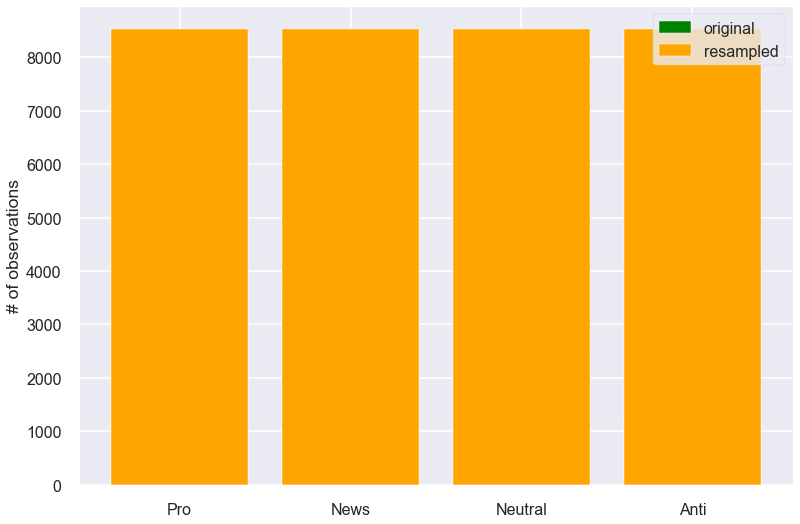

In [211]:
labels = ['Pro', 'News', 'Neutral', 'Anti'] 

# Get all possible labels
plt.bar(labels,df_train['sentiment'].value_counts() ,color='green')
plt.bar(labels,up_sampled['sentiment'].value_counts() ,color='orange')
plt.xticks(labels, ['Pro', 'News', 'Neutral', 'Anti'] )
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

# Train Test split with balanced upsampled data 

In [218]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# X -> features, y -> label
up_y =  up_sampled['sentiment']
up_X =  up_sampled['clean_sentences']

# dividing X, y into train and test data
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y, 
                                random_state = 42)

# extracting features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
up_V_train_X = vectorizer.fit_transform(up_X_train)
up_V_test_X = vectorizer.transform(up_X_test)


# Import the scaler module
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler ()
# Scale data
up_X_train_scaled = scaler.fit_transform(up_V_train_X)
up_X_test_scaled = scaler.transform(up_V_test_X)


# modelling 

In [220]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(up_V_train_X,up_y_train)
up_svm_predictions = svm_model_linear.predict(up_V_test_X)
 
# model accuracy for V_test_X 
accuracy = svm_model_linear.score(up_V_test_X, up_y_test)
 
# creating a confusion matrix
cm2 = confusion_matrix(up_y_test, up_svm_predictions)

print('Classification Report SVM')
print(classification_report(up_y_test, up_svm_predictions))

Classification Report SVM
              precision    recall  f1-score   support

          -1       0.94      0.99      0.96      2070
           0       0.88      0.93      0.90      2134
           1       0.89      0.75      0.82      2147
           2       0.89      0.95      0.92      2179

    accuracy                           0.90      8530
   macro avg       0.90      0.90      0.90      8530
weighted avg       0.90      0.90      0.90      8530



In [221]:
# training a Linear Logistics 
from sklearn.linear_model import LogisticRegression
lm_vt = LogisticRegression(multi_class='ovr').fit(up_V_train_X, up_y_train)
up_pred_lr_vt = lm_vt.predict(up_V_test_X)

# printing the classification report
print('Classification Report Linear logistics')
print(classification_report(up_y_test, up_pred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.91      0.96      0.94      2070
           0       0.84      0.87      0.86      2134
           1       0.86      0.69      0.77      2147
           2       0.84      0.93      0.89      2179

    accuracy                           0.86      8530
   macro avg       0.86      0.86      0.86      8530
weighted avg       0.86      0.86      0.86      8530



In [223]:
# Training the scaled data for the Linear Logistics

slm_vt = LogisticRegression(multi_class='ovr').fit(up_X_train_scaled, up_y_train)
up_spred_lr_vt = slm_vt.predict(up_X_test_scaled)
print('Classification Report Linear logistics')
print(classification_report(up_y_test,up_spred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.94      0.99      0.97      2070
           0       0.88      0.95      0.92      2134
           1       0.93      0.75      0.83      2147
           2       0.90      0.96      0.93      2179

    accuracy                           0.91      8530
   macro avg       0.91      0.91      0.91      8530
weighted avg       0.91      0.91      0.91      8530



# Hyperparameter tuning

Getting the best hyperparameters for the upsampled data

In [ ]:
# Import Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# number of folds to be tested on
nfolds = 5

# the values of c to check for
Cs = [0.001, 0.01, 0.1, 1, 10]

# the values of gamma
gammas = [0.001, 0.01, 0.1, 1]

# Creating the parameters dictionary
param_grid = {
    'C'     : Cs,
    'gamma' : gammas
    }

# Applying the grid search and comparing based on the f1 score
grid_SVM = GridSearchCV(SVC(kernel = 'linear'), param_grid, scoring='f1', cv=nfolds)
grid_SVM.fit(V_train_X, y_train)

# Getting the best parameters of grid search
grid_SVM.best_params_


# Beast feature selection

In [ ]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)


# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(V_train_X, y_train)

# Fit model to the transformed data
SVM_k_best = SVC(kernel='linear', degree=0.001, C=0.001).fit(X_train_kbest, y_train)


# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(V_test_X)

# Generate predictions from var thresh model
pred_lm_kbest = SVM_k_best.predict(X_test_kbest)


#rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, pred_lm_kbest))

## Creating the Data for donwsampling to min class

Creating a data frame with down sampled data to min data available in the classes, which is class Anti(-1) with the count of 1296

In [194]:
# Pick a class size of roughly half the size of the largest size
min_class_size = 1296

# Downsample classes with more than 5000 observations
pro_down_sampled = resample(processed_df_train[processed_df_train['sentiment']==1],
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples= min_class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
neutral_down_sampled = resample(processed_df_train[processed_df_train['sentiment']==0],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= min_class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
anti_down_sampled = resample(processed_df_train[processed_df_train['sentiment']==-1],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= min_class_size, # match number in class_size
                          random_state=27) # reproducible results

# Upsample classes with less than 5000 observations
news_down_sampled = resample(processed_df_train[processed_df_train['sentiment']==2],
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples= min_class_size, # match number in class_size
                          random_state=27) # reproducible results





In [195]:
# Combine sampled classes with majority class
down_sampled = pd.concat([pro_down_sampled, neutral_down_sampled, anti_down_sampled, news_down_sampled])

# Check new class counts
down_sampled['sentiment'].value_counts()


 1    1296
 0    1296
-1    1296
 2    1296
Name: sentiment, dtype: int64

In [196]:
down_sampled.shape

(5184, 11)

In [197]:
down_sampled.head()

,sentiment,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences,stem_clean_sentences,lemma_stem_clean_sentences,lemma_clean_sentences
11729,1,ubcforestry funding from genomebc will support...,977844,"[ubcforestry, funding, from, genomebc, will, s...","[ubcforestry, funding, genomebc, support, sall...","[ubcforestry, funding, genomebc, support, sall...","[ubcforestri, fund, genomebc, support, sallyna...",ubcforestry funding genomebc support sallynait...,ubcforestri fund genomebc support sallynaitken...,ubcforestri fund genomebc support sallynaitken...,ubcforestry funding genomebc support sallynait...
8308,1,yadimoiina gag orders sure hes definitely gree...,441956,"[yadimoiina, gag, orders, sure, hes, definitel...","[yadimoiina, gag, orders, sure, hes, definitel...","[yadimoiina, gag, order, sure, he, definitely,...","[yadimoiina, gag, order, sure, hes, definit, g...",yadimoiina gag orders sure hes definitely gree...,yadimoiina gag order sure hes definit green do...,yadimoiina gag order sure hes definit green do...,yadimoiina gag order sure he definitely green ...
7159,1,pattonoswalt not ominous at all he also wants ...,978938,"[pattonoswalt, not, ominous, at, all, he, also...","[pattonoswalt, ominous, also, wants, names, an...","[pattonoswalt, ominous, also, want, name, anyo...","[pattonoswalt, omin, also, want, name, anyon, ...",pattonoswalt ominous also wants names anyone w...,pattonoswalt omin also want name anyon work cl...,pattonoswalt omin also want name anyon work cl...,pattonoswalt ominous also want name anyone wor...
5644,1,melissajpeltier in case you forgot about that ...,587737,"[melissajpeltier, in, case, you, forgot, about...","[melissajpeltier, case, forgot, chinese, hoax,...","[melissajpeltier, case, forgot, chinese, hoax,...","[melissajpelti, case, forgot, chines, hoax, gl...",melissajpeltier case forgot chinese hoax globa...,melissajpelti case forgot chines hoax global w...,melissajpelti case forgot chines hoax global w...,melissajpeltier case forgot chinese hoax globa...
6732,1,sethmacfarlane hrc proposes installing half a ...,804767,"[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlane, hrc, proposes, installing, ha...","[sethmacfarlan, hrc, propos, instal, half, bil...",sethmacfarlane hrc proposes installing half bi...,sethmacfarlan hrc propos instal half billion s...,sethmacfarlan hrc propos instal half billion s...,sethmacfarlane hrc proposes installing half bi...


In [199]:
df_train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

## let us have a look at the new distribution of data after downsampling

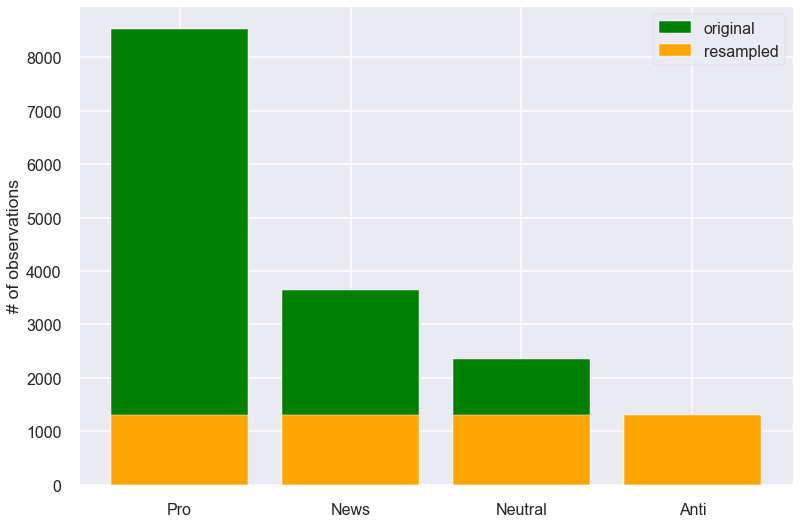

In [212]:
labels = ['Pro', 'News', 'Neutral', 'Anti'] 

# Get all possible labels
plt.bar(labels,df_train['sentiment'].value_counts() ,color='green')
plt.bar(labels,down_sampled['sentiment'].value_counts() ,color='orange')
plt.xticks(labels, ['Pro', 'News', 'Neutral', 'Anti'] )
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

# Train Test split with balanced downsampled data 

spliting and transforming the down sampled data and scaling it at the same town for those algorithms that need scaled data


In [224]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# X -> features, y -> label
down_y =  down_sampled['sentiment']
down_X =  down_sampled['clean_sentences']

# dividing X, y into train and test data
down_X_train, down_X_test, down_y_train, down_y_test = train_test_split(down_X, down_y, 
                                random_state = 42)

# extracting features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
down_V_train_X = vectorizer.fit_transform(down_X_train)
down_V_test_X = vectorizer.transform(down_X_test)


# Import the scaler module
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler ()
# Scale data
down_X_train_scaled = scaler.fit_transform(down_V_train_X)
down_X_test_scaled = scaler.transform(down_V_test_X)


# modelling the down scaled data

In [225]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(down_V_train_X,down_y_train)
down_svm_predictions = svm_model_linear.predict(down_V_test_X)
 
# model accuracy for V_test_X 
accuracy = svm_model_linear.score(down_V_test_X, down_y_test)
 
# creating a confusion matrix
cm2 = confusion_matrix(down_y_test, down_svm_predictions)

print('Classification Report SVM')
print(classification_report(down_y_test, down_svm_predictions))

Classification Report SVM
              precision    recall  f1-score   support

          -1       0.84      0.78      0.81       294
           0       0.63      0.70      0.67       306
           1       0.70      0.58      0.63       352
           2       0.77      0.87      0.81       344

    accuracy                           0.73      1296
   macro avg       0.73      0.73      0.73      1296
weighted avg       0.73      0.73      0.73      1296



In [226]:
# training a Linear Logistics 
from sklearn.linear_model import LogisticRegression
lm_vt = LogisticRegression(multi_class='ovr').fit(down_V_train_X, down_y_train)
down_pred_lr_vt = lm_vt.predict(down_V_test_X)

# printing the classification report
print('Classification Report Linear logistics')
print(classification_report(down_y_test, down_pred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.77      0.77      0.77       294
           0       0.65      0.66      0.66       306
           1       0.70      0.53      0.60       352
           2       0.72      0.88      0.79       344

    accuracy                           0.71      1296
   macro avg       0.71      0.71      0.71      1296
weighted avg       0.71      0.71      0.70      1296



In [228]:
# Training the scaled data for the Linear Logistics

slm_vt = LogisticRegression(multi_class='ovr').fit(down_X_train_scaled, down_y_train)
down_spred_lr_vt = slm_vt.predict(down_X_test_scaled)
print('Classification Report Linear logistics')
print(classification_report(down_y_test,down_spred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.83      0.81      0.82       294
           0       0.65      0.73      0.69       306
           1       0.74      0.56      0.64       352
           2       0.76      0.87      0.81       344

    accuracy                           0.74      1296
   macro avg       0.74      0.74      0.74      1296
weighted avg       0.74      0.74      0.74      1296



# Hyperparameter tuning

Getting the best hyperparameters for the downsampled data

In [ ]:
# Import Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# number of folds to be tested on
nfolds = 2

# the values of c to check for
Cs = [0.001, 0.01, 0.1, 1, 10]

# the values of gamma
gammas = [0.001, 0.01, 0.1, 1]

# Creating the parameters dictionary
param_grid = {
    'C'     : Cs,
    'gamma' : gammas
    }

# Applying the grid search and comparing based on the f1 score
grid_SVM = GridSearchCV(SVC(kernel='poly'), param_grid, scoring='f1', cv=nfolds)
grid_SVM.fit(V_train_X, y_train)

# Getting the best parameters of grid search
grid_SVM.best_params_


# Best feature selection

In [ ]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)


# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(V_train_X, y_train)

# Fit model to the transformed data
SVM_k_best = SVC(kernel='linear', degree=0.001, C=0.001).fit(X_train_kbest, y_train)


# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(V_test_X)

# Generate predictions from var thresh model
pred_lm_kbest = SVM_k_best.predict(X_test_kbest)


#rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, pred_lm_kbest))

# Creating sample data with SMOTE

In [32]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# X -> features, y -> label
y =  sampled['sentiment']
X =  sampled['clean_sentences']

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                random_state = 42)

# extracting features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
V_train_X = vectorizer.fit_transform(X_train)
V_test_X = vectorizer.transform(X_test)


# Import the scaler module
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler ()
# Scale data
X_train_scaled = scaler.fit_transform(V_train_X)
x_test_scaled = scaler.transform(V_test_X)


In [33]:

 # training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train_scaled, y_train)
dtree_predictions = dtree_model.predict(x_test_scaled)
 
# creating a confusion matrix
cm1 = confusion_matrix(y_test, dtree_predictions)
print('Classification Report Decision Tree')
print(classification_report(y_test, dtree_predictions))


Classification Report Decision Tree
              precision    recall  f1-score   support

          -1       0.35      0.47      0.40      1203
           0       0.95      0.03      0.06      1266
           1       0.41      0.75      0.53      2008
           2       0.59      0.22      0.32      1273

    accuracy                           0.41      5750
   macro avg       0.58      0.36      0.33      5750
weighted avg       0.56      0.41      0.35      5750



In [34]:

# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(V_train_X, y_train)
svm_predictions = svm_model_linear.predict(V_test_X)
 
# model accuracy for V_test_X 
accuracy = svm_model_linear.score(V_test_X, y_test)
 
# creating a confusion matrix
cm2 = confusion_matrix(y_test, svm_predictions)

print('Classification Report SVM')
print(classification_report(y_test, svm_predictions))

Classification Report SVM
              precision    recall  f1-score   support

          -1       0.84      0.90      0.87      1203
           0       0.77      0.73      0.75      1266
           1       0.77      0.75      0.76      2008
           2       0.81      0.82      0.82      1273

    accuracy                           0.79      5750
   macro avg       0.80      0.80      0.80      5750
weighted avg       0.79      0.79      0.79      5750



In [44]:
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(V_train_X, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(V_train_X, y_train)

poly_pred = poly.predict(V_test_X)
rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, poly_pred))

Classification Report poly_pred 
              precision    recall  f1-score   support

          -1       0.98      0.97      0.98      1203
           0       0.98      0.82      0.89      1266
           1       0.79      0.96      0.87      2008
           2       0.95      0.79      0.86      1273

    accuracy                           0.89      5750
   macro avg       0.93      0.89      0.90      5750
weighted avg       0.91      0.89      0.89      5750



In [45]:
print('Classification Report rbf_pred ')
print(classification_report(y_test, rbf_pred))

Classification Report rbf_pred 
              precision    recall  f1-score   support

          -1       0.81      0.48      0.60      1203
           0       0.72      0.25      0.37      1266
           1       0.45      0.91      0.60      2008
           2       0.82      0.34      0.48      1273

    accuracy                           0.55      5750
   macro avg       0.70      0.49      0.51      5750
weighted avg       0.66      0.55      0.52      5750



In [35]:

# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(V_train_X, y_train)
 
# accuracy on V_test_X
accuracy = knn.score(V_test_X, y_test)
print(accuracy)
 
# creating a confusion matrix
knn_predictions = knn.predict(V_test_X)
cm3 = confusion_matrix(y_test, knn_predictions)

print('Classification Report KNN')
print(classification_report(y_test, knn_predictions))


0.6466086956521739
Classification Report KNN
              precision    recall  f1-score   support

          -1       0.64      0.81      0.71      1203
           0       0.57      0.62      0.59      1266
           1       0.70      0.53      0.61      2008
           2       0.68      0.70      0.69      1273

    accuracy                           0.65      5750
   macro avg       0.65      0.67      0.65      5750
weighted avg       0.65      0.65      0.64      5750



In [36]:

# training a Naive classifierBayes 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(V_train_X.toarray(), y_train)
gnb_predictions = gnb.predict(V_test_X.toarray())
 
# accuracy on V_test_X
accuracy = gnb.score(V_test_X.toarray(), y_test)
print(accuracy)
 
# creating a confusion matrix
cm4 = confusion_matrix(y_test, gnb_predictions)


print('Classification Report Naive Bayes')
print(classification_report(y_test, gnb_predictions))


0.6052173913043478
Classification Report Naive Bayes
              precision    recall  f1-score   support

          -1       0.49      0.99      0.65      1203
           0       0.70      0.58      0.64      1266
           1       0.83      0.31      0.45      2008
           2       0.62      0.73      0.67      1273

    accuracy                           0.61      5750
   macro avg       0.66      0.65      0.60      5750
weighted avg       0.68      0.61      0.58      5750



In [41]:

# training a Naive classifierBayes 
from sklearn.naive_bayes import GaussianNB
sgnb = GaussianNB().fit(X_train_scaled.toarray(), y_train)
sgnb_predictions = sgnb.predict(V_test_X.toarray())
 
# accuracy on V_test_X
accuracy = sgnb.score(x_test_scaled.toarray(), y_test)
print(accuracy)
 
# creating a confusion matrix
cm4 = confusion_matrix(y_test, sgnb_predictions)


print('Classification Report Naive Bayes')
print(classification_report(y_test, sgnb_predictions))


0.6031304347826087
Classification Report Naive Bayes
              precision    recall  f1-score   support

          -1       0.48      0.99      0.65      1203
           0       0.70      0.58      0.63      1266
           1       0.83      0.31      0.45      2008
           2       0.62      0.72      0.67      1273

    accuracy                           0.60      5750
   macro avg       0.66      0.65      0.60      5750
weighted avg       0.68      0.60      0.58      5750



In [37]:
b

In [ ]:
# accuracy on V_test_X
accuracy = gnb.score(pred_lr_vt, y_test)
print(accuracy)

In [38]:
print('Classification Report Linear logistics')
print(classification_report(y_test, pred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.84      0.85      0.85      1203
           0       0.76      0.67      0.71      1266
           1       0.73      0.77      0.75      2008
           2       0.79      0.79      0.79      1273

    accuracy                           0.77      5750
   macro avg       0.78      0.77      0.77      5750
weighted avg       0.77      0.77      0.77      5750



In [40]:
slm_vt = LogisticRegression(multi_class='ovr').fit(X_train_scaled, y_train)
spred_lr_vt = slm_vt.predict(x_test_scaled)
print('Classification Report Linear logistics')
print(classification_report(y_test,spred_lr_vt))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90      1203
           0       0.79      0.75      0.77      1266
           1       0.79      0.78      0.78      2008
           2       0.81      0.84      0.82      1273

    accuracy                           0.81      5750
   macro avg       0.82      0.82      0.82      5750
weighted avg       0.81      0.81      0.81      5750



In [84]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=42).fit(V_train_X, y_train)
forest_pred = forest.predict(x_test_scaled)
print('Classification Report Linear logistics')
print(classification_report(y_test, forest_pred))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.94      0.93      0.93      1203
           0       0.84      0.76      0.80      1266
           1       0.78      0.80      0.79      2008
           2       0.77      0.82      0.80      1273

    accuracy                           0.82      5750
   macro avg       0.83      0.83      0.83      5750
weighted avg       0.83      0.82      0.82      5750



# Creating A pipeline for modelling

In [99]:
df.head()

,tweetid,sentiment
0,169760,2
1,35326,0
2,224985,1
3,476263,2
4,872928,1


In [109]:
# Seperate features and tagret variables
tX = clean_df['message']
ty = clean_df['sentiment']

# Split the train data to create validation dataset
tX_train, tX_test, ty_train, ty_test = train_test_split(tX, ty, test_size=0.20, random_state=42)

In [110]:
from sklearn.svm import LinearSVC

#Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC(class_weight='balanced'))])

In [112]:
# Linear SVC
lsvc.fit(tX_train, ty_train)
lsvc_y_predict = lsvc.predict(tX_test)
print('Classification Report Linear logistics')
print(classification_report(ty_test, lsvc_y_predict))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.64      0.56      0.60       278
           0       0.53      0.51      0.52       425
           1       0.82      0.80      0.81      1755
           2       0.73      0.83      0.77       706

    accuracy                           0.74      3164
   macro avg       0.68      0.67      0.68      3164
weighted avg       0.74      0.74      0.74      3164



# Training with Sampled Data

In [115]:
sampled.shape

(23000, 8)

In [116]:
# Seperate features and tagret variables
sX = sampled['message']
sy = sampled['sentiment']

# Split the train data to create validation dataset
sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.20, random_state=42)

In [117]:
# Linear SVC
lsvc.fit(sX_train, sy_train)
slsvc_y_predict = lsvc.predict(sX_test)
print('Classification Report Linear logistics')
print(classification_report(sy_test, slsvc_y_predict))

Classification Report Linear logistics
              precision    recall  f1-score   support

          -1       0.88      0.97      0.92       961
           0       0.82      0.85      0.84      1003
           1       0.88      0.75      0.81      1631
           2       0.83      0.91      0.86      1005

    accuracy                           0.85      4600
   macro avg       0.85      0.87      0.86      4600
weighted avg       0.86      0.85      0.85      4600



# Hyperparameter tuning

In [80]:
# Import Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# number of folds to be tested on
nfolds = 2

# the values of c to check for
Cs = [0.001, 0.01, 0.1, 1, 10]

# the values of gamma
gammas = [0.001, 0.01, 0.1, 1]

# Creating the parameters dictionary
param_grid = {
    'C'     : Cs,
    'gamma' : gammas
    }

# Applying the grid search and comparing based on the f1 score
grid_SVM = GridSearchCV(SVC(kernel='poly'), param_grid, scoring='f1', cv=nfolds)
grid_SVM.fit(V_train_X, y_train)

# Getting the best parameters of grid search
grid_SVM.best_params_


GridSearchCV(cv=2, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='f1')

In [81]:
grid_SVM.best_params_


{'C': 0.001, 'gamma': 0.001}

In [92]:
#rbf = SVC(kernel='rbf', gamma=0.001, C=0.001).fit(V_train_X, y_train)
poly = SVC(kernel='poly', degree=0.001, C=0.100).fit(V_train_X, y_train)

poly_pred = poly.predict(V_test_X)
#rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, poly_pred))

Classification Report poly_pred 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1203
           0       0.00      0.00      0.00      1266
           1       0.35      1.00      0.52      2008
           2       0.00      0.00      0.00      1273

    accuracy                           0.35      5750
   macro avg       0.09      0.25      0.13      5750
weighted avg       0.12      0.35      0.18      5750



# Selecting Best Features

In [86]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)


# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(V_train_X, y_train)

# Fit model to the transformed data
SVM_k_best = SVC(kernel='linear', degree=0.001, C=0.001).fit(X_train_kbest, y_train)


# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(V_test_X)

# Generate predictions from var thresh model
pred_lm_kbest = SVM_k_best.predict(X_test_kbest)


#rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, pred_lm_kbest))

In [87]:
X_train_kbest.shape

(17250, 20)

In [88]:
# Fit model to the transformed data
SVM_k_best = SVC(kernel='poly', degree=0.001, C=0.001).fit(X_train_kbest, y_train)

In [90]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(V_test_X)

# Generate predictions from var thresh model
pred_lm_kbest = SVM_k_best.predict(X_test_kbest)

In [91]:
#rbf_pred = rbf.predict(V_test_X)
print('Classification Report poly_pred ')
print(classification_report(y_test, pred_lm_kbest))

Classification Report poly_pred 
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1203
           0       0.00      0.00      0.00      1266
           1       0.35      1.00      0.52      2008
           2       0.00      0.00      0.00      1273

    accuracy                           0.35      5750
   macro avg       0.09      0.25      0.13      5750
weighted avg       0.12      0.35      0.18      5750



# making a Submission

In [235]:
#traing the model with the entire data
yf = up_sampled['sentiment']
Xf = up_sampled['message']

In [47]:
clean_test = data_cleaner(df_test, 'message')


In [48]:
clean_test = token_lemmatizer_stemmer(clean_test)
clean_test.head()

,message,tweetid,tokens,token_no_stop_word,lemma,stem,clean_sentences
0,europe will now be looking to china to make su...,169760,"[europe, will, now, be, looking, to, china, to...","[europe, looking, china, make, sure, alone, fi...","[europe, looking, china, make, sure, alone, fi...","[europ, look, china, make, sure, alon, fight, ...",europ look china make sure alon fight climat u...
1,combine this with the polling of staffers re c...,35326,"[combine, this, with, the, polling, of, staffe...","[combine, polling, staffers, climate, change, ...","[combine, polling, staffer, climate, change, w...","[combin, poll, staffer, climat, chang, woman, ...",combin poll staffer climat chang woman right f...
2,the scary unimpeachable evidence that climate ...,224985,"[the, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...","[scary, unimpeachable, evidence, climate, chan...","[scari, unimpeach, evid, climat, chang, alread...",scari unimpeach evid climat chang alreadi urlw...
3,karoli morgfair osborneink dailykos \nputin go...,476263,"[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailyko, putin,...",karoli morgfair osborneink dailyko putin got j...
4,fakewillmoore female orgasms cause global warm...,872928,"[fakewillmoore, female, orgasms, cause, global...","[fakewillmoore, female, orgasms, cause, global...","[fakewillmoore, female, orgasm, cause, global,...","[fakewillmoor, femal, orgasm, caus, global, wa...",fakewillmoor femal orgasm caus global warm sar...


In [118]:
X_testf = clean_test['message']

In [260]:
# extracting features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(ngram_range = (1, 3))
V_train_Xf = vectorizer1.fit_transform(Xf)
V_test_Xf = vectorizer1.transform(X_testf)

In [261]:
# Linear SVC:
flsvc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC(class_weight='balanced'))])

In [54]:
V_test_Xf.shape

(10546, 9689)

In [262]:
# Import the scaler module
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler ()

# Scale data
X_Train_f = scaler.fit_transform(V_train_Xf)
X_Test_f = scaler.transform(V_test_Xf)

In [263]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model_linear_f = SVC(kernel = 'linear', C = 1).fit(V_train_Xf,yf)
final_preds = svm_model_linear_f.predict(V_test_Xf)


In [252]:
# linear logistic 
slm_vt_f_o = LogisticRegression(multi_class='ovr').fit(X_Train_f, yf)
spred_lr_vt_f = slm_vt_f_o.predict(X_Test_f)

In [253]:
# Linear SVC
flsvc.fit(Xf, yf)
flsvc_y_predict = lsvc.predict(X_testf)

In [136]:
import pickle

# save the model to disk
model_name = ['SVC_linear', "Linear_svC"]
models = [svm_model_linear_f, slm_vt_f_o, rbf_f, poly_f, sgnbf, flsvc]
for i in range(len(models)):
        filename = model_name[i] + '2.pkl'
        pickle.dump(models[i], open(filename, 'wb'))



In [254]:
preds = [final_preds, spred_lr_vt_f, flsvc_y_predict]
preds[0]

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [258]:
def submissions(preds):
    
    
    model = ['SVC_linear', 'SVC_balanced', 'LogisticRegression']
    
    for i in range(len(model)):
        daf = pd.DataFrame(preds[i], columns=['sentiment'])
        output = pd.DataFrame({"tweetid":df_test['tweetid']})
        final = output.join(daf)
        final_name = model[i] +"_finalise4.csv"
        final.to_csv(final_name, index=False)
        

    return final

In [259]:
df = submissions([final_preds, spred_lr_vt_f, rbf_predf, poly_predf, sgnb_predictionsf, flsvc_y_predict])

In [257]:
df.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [232]:
stri = 'mplio getã¢â‚¬â¦s that9808'
p = re.sub(r'[^a-z0-9 ]', r'', stri)
p

'mplio gets that9808'